In [1]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import datetime
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
pd.set_option('display.max_columns', None)
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
import time
import statsmodels.api as sm

In [2]:
df=pd.read_csv('DATA.csv', encoding='cp932')
df=df.dropna(axis=0)

y=df['EColi.']
X=df.loc[:, ['up_down', 'curvature', 'inclination', 'tilt_direction', 'altitude', 'disto_river', 'disto_stations', 
             'disto_mainroad', 'disto_syorizyo', 'supply_hours', 'no_water_days', 'total_population ', 'population_served',
             'popu-served', 'number_taps', 'pipelength', 'pipelength_per_pipe', 'served/pipes', '(popu-served)/pipes', 
             'oldest_pipe_age', 'ST', 'RSF', 'FL', 'PF', 'RF', 'ratio', 'source_ecoli']]

In [3]:
# 分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3,
                                                  random_state=1, stratify=y)
print('Labels counts in y:', np.bincount(y))
print('Lables counts in y_train:', np.bincount(y_train))
print('Lables counts in y_test:', np.bincount(y_test))

X=(X-X.mean(axis=0))/X.std(axis=0)
X_train_std=(X_train-X_train.mean(axis=0))/X_train.std(axis=0)
X_test_std=(X_test-X_train.mean(axis=0))/X_train.std(axis=0)

def threshold(fare):
    if fare<=0:
        return 0
    else:
        return 1
    
X_train_std['ST']=X_train_std['ST'].apply(threshold)
X_train_std['RSF']=X_train_std['RSF'].apply(threshold)
X_train_std['FL']=X_train_std['FL'].apply(threshold)
X_train_std['PF']=X_train_std['PF'].apply(threshold)
X_train_std['RF']=X_train_std['RF'].apply(threshold)
X_test_std['ST']=X_test_std['ST'].apply(threshold)
X_test_std['RSF']=X_test_std['RSF'].apply(threshold)
X_test_std['FL']=X_test_std['FL'].apply(threshold)
X_test_std['PF']=X_test_std['PF'].apply(threshold)
X_test_std['RF']=X_test_std['RF'].apply(threshold)


# 分割する
X_cross=(X-X.mean(axis=0))/X.std(axis=0)
X_cross['ST']=X_cross['ST'].apply(threshold)
X_cross['RSF']=X_cross['RSF'].apply(threshold)
X_cross['FL']=X_cross['FL'].apply(threshold)
X_cross['PF']=X_cross['PF'].apply(threshold)
X_cross['RF']=X_cross['RF'].apply(threshold)

Labels counts in y: [ 98 120]
Lables counts in y_train: [68 84]
Lables counts in y_test: [30 36]


# random forest

0.7368421052631579
0.7121212121212122


Text(0, 0.5, 'true label')

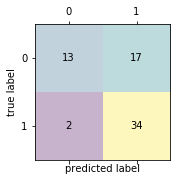

In [4]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(max_depth=3, criterion='entropy', n_estimators=29, random_state=1)
forest.fit(X_train_std, y_train)
print(forest.score(X_train_std, y_train))
print(forest.score(X_test_std, y_test))

from sklearn.metrics import confusion_matrix
y_pred=forest.predict(X_test_std)
confmat=confusion_matrix(y_true=y_test, y_pred=y_pred)

import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('predicted label')
plt.ylabel('true label')

# importance

In [8]:
indices

array([10,  4,  8,  5,  6, 15,  7, 17, 11, 12,  2,  3, 18, 26, 16, 14,  0,
        9, 13, 23, 25, 19,  1, 21, 20, 22, 24], dtype=int64)

 1) no_water_days                  0.136608
 2) altitude                       0.104122
 3) disto_syorizyo                 0.090071
 4) disto_river                    0.084559
 5) disto_stations                 0.065721
 6) pipelength                     0.048394
 7) disto_mainroad                 0.045966
 8) served/pipes                   0.043923
 9) total_population               0.035541
10) population_served              0.035177


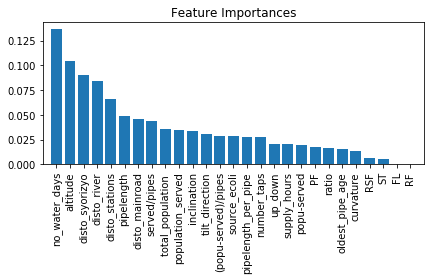

In [9]:
from sklearn.ensemble import RandomForestClassifier
feat_labels=X.columns[0:]
forest=RandomForestClassifier(max_depth=3, criterion='entropy', n_estimators=29, random_state=1)
forest.fit(X_train_std, y_train)
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train_std.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

 1) no_water_days                  0.136608
 2) altitude                       0.104122
 3) disto_syorizyo                 0.090071
 4) disto_river                    0.084559
 5) disto_stations                 0.065721
 6) pipelength                     0.048394
 7) disto_mainroad                 0.045966
 8) served/pipes                   0.043923
 9) total_population               0.035541
10) population_served              0.035177
11) inclination                    0.033890
12) tilt_direction                 0.030675
13) (popu-served)/pipes            0.028565
14) source_ecoli                   0.028260
15) pipelength_per_pipe            0.027274
16) number_taps                    0.027151
17) up_down                        0.020342
18) supply_hours                   0.020057
19) popu-served                    0.019507
20) PF                             0.017161
21) ratio                          0.016618
22) oldest_pipe_age                0.015437
23) curvature                   

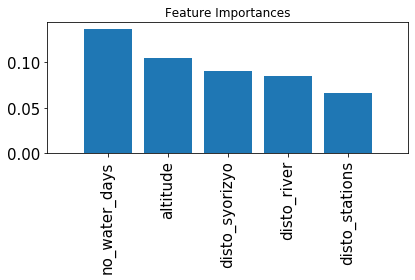

In [17]:
from sklearn.ensemble import RandomForestClassifier
feat_labels=X.columns[0:]
forest=RandomForestClassifier(max_depth=3, criterion='entropy', n_estimators=29, random_state=1)
forest.fit(X_train_std, y_train)
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train_std.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(5), importances[indices[:5]], align='center')
plt.xticks(range(5), feat_labels[indices[:5]], rotation=90)
plt.xlim([-1, 5])
plt.tick_params(labelsize=15)
plt.tight_layout()

In [121]:
coef = pd.DataFrame(importances.reshape((27, -1)), X_train_std.columns, columns=["回帰係数"])
interce = pd.DataFrame([lr.intercept_], index=["定数項"], columns=["回帰係数"])
df_coef = pd.concat([coef, interce])

In [122]:
df=coef.reset_index().rename(columns={'index':'feature'})
df['sort']=df['回帰係数'].apply(lambda x: np.abs(x))
a=df.sort_values(['sort'],ascending=False)

In [124]:
a.to_csv('RF_feature.csv')

# ロジスティック回帰

0.7105263157894737
0.696969696969697


C:\Users\kurokiso\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0, 0.5, 'true label')

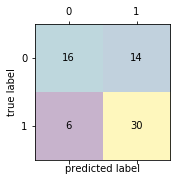

In [6]:
lr=LogisticRegression(C=100, random_state=1)
lr.fit(X_train_std, y_train)
print(lr.score(X_train_std, y_train))
print(lr.score(X_test_std, y_test))

from sklearn.metrics import confusion_matrix
y_pred=lr.predict(X_test_std)
confmat=confusion_matrix(y_true=y_test, y_pred=y_pred)

import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('predicted label')
plt.ylabel('true label')

In [128]:
lr.coef_

array([[ 0.29289772, -0.04599312,  0.69694242, -0.32097436, -0.87974058,
         0.40241817,  2.29735938, -0.17448568, -0.83087964, -0.93946655,
        -0.45396508, -2.88867139, -4.20903789,  2.96832295, -4.24138524,
         0.33274289,  5.43396413, -1.01162239,  0.16010062,  6.02981287,
         0.69124789,  2.46190973, -6.06818201, -7.36526088, -0.39957068,
        -5.83576494,  2.25273352]])

In [129]:
coef = pd.DataFrame(lr.coef_.reshape((27, -1)), X_train_std.columns, columns=["回帰係数"])
interce = pd.DataFrame([lr.intercept_], index=["定数項"], columns=["回帰係数"])
df_coef = pd.concat([coef, interce])
df_coef

,回帰係数
up_down,0.292898
curvature,-0.045993
inclination,0.696942
tilt_direction,-0.320974
altitude,-0.879741
disto_river,0.402418
disto_stations,2.297359
disto_mainroad,-0.174486
disto_syorizyo,-0.830880
supply_hours,-0.939467


In [130]:
df=coef.reset_index().rename(columns={'index':'feature'})
df['sort']=df['回帰係数'].apply(lambda x: np.abs(x))
a=df.sort_values(['sort'],ascending=False)

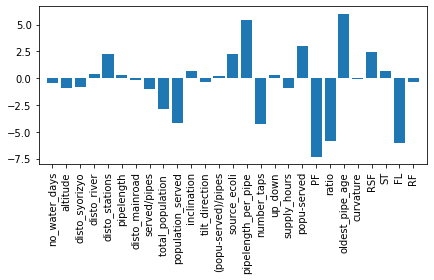

In [135]:
plt.bar(range(X_train.shape[1]), a['回帰係数'][indices], align='center')
plt.xticks(range(X_train.shape[1]), a['feature'][indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from matplotlib.font_manager import FontProperties
from sklearn import datasets

In [10]:
logit_model = sm.Logit(y_train, X_train_std)
result = logit_model.fit()
print(result.summary())

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix